# Adversarial robustness

In [22]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary

import time

from pennylane import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

from utils.models import NetCNN, NeuralNetwork, QNN, PGD
from utils.tools import get_dataset, visualise_data, train_and_plot_accuracy, print_model_summary, evaluate_under_attack

In [23]:
digits = [3, 5, 8, 9] # 4 class
# digits = [5, 8] # binary

n_classes = len(digits)
n_px = 16 # can try 8 (then use 64 qubit device and AngleEmbedding)

n_qubits = int(np.log2(n_px * n_px)) # for AmplitudeEmbedding
n_layers = 32

train_size = 10000
test_size = 2000

batch_size = int(np.sqrt(train_size))
epochs = 30
lr = 3e-3

In [24]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
device = "cpu"
print(f"Using {device} device")

Using cpu device


## Load trained models

In [25]:
model_cnn = NetCNN(n_px=n_px, n_classes=n_classes).to(device)
model_cnn.load_state_dict(torch.load("model_cnn.pth"))
model_cnn.eval()

NetCNN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=256, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=4, bias=True)
)

In [26]:
model_feed_forward = NeuralNetwork(n_px=n_px, n_classes=n_classes).to(device)
model_feed_forward.load_state_dict(torch.load("model_feedforward.pth"))
model_feed_forward.eval()

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=256, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [27]:
model_qml32 = QNN(n_qubits=n_qubits, n_classes=n_classes, n_layers=n_layers).to(device)
model_qml32.load_state_dict(torch.load("model_qml32.pth"))
model_qml32.eval()

QNN(
  (qlayer): <Quantum Torch Layer: func=circuit>
  (fc): Linear(in_features=8, out_features=4, bias=True)
)

## Load data and test

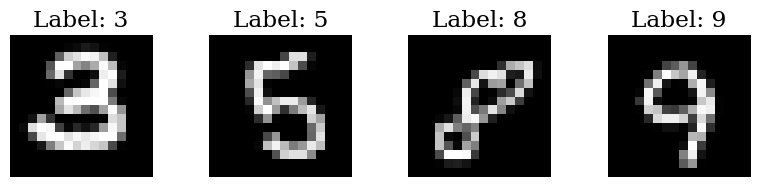

In [28]:
# Load and prepare dataset
(x_train, y_train), (x_test, y_test) = get_dataset(digits=digits, n_px=n_px, train_size=train_size, test_size=test_size)
train_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(x_test,  y_test),  batch_size=batch_size)

# show one image from each class (in the train- and testsets, the images are randomly permuted)
x_vis = [(x_train[y_train == i])[0].squeeze(0) for i in range(len(digits))]
y_vis = digits

visualise_data(x_vis, y_vis)

In [8]:
# Settings
epsilons = np.linspace(0, 0.2, 10).numpy() 
x_perturb = x_test.to(device)
y_perturb = y_test.to(device)
alpha = 1e-2
num_iter = 100

# Evaluate models
accs_cnn = evaluate_under_attack(model_cnn, model_cnn, x_perturb, y_perturb, epsilons, alpha, num_iter, batch_size)
accs_neural = evaluate_under_attack(model_feed_forward, model_feed_forward, x_perturb, y_perturb, epsilons, alpha, num_iter, batch_size)
accs_qml = evaluate_under_attack(model_qml32, model_qml32, x_perturb, y_perturb, epsilons, alpha, num_iter, batch_size)

Attack on 
NetCNN completed in 26.04 seconds.
Attack on 
NeuralNetwork completed in 1.31 seconds.
Attack on 
QNN completed in 1460.73 seconds.


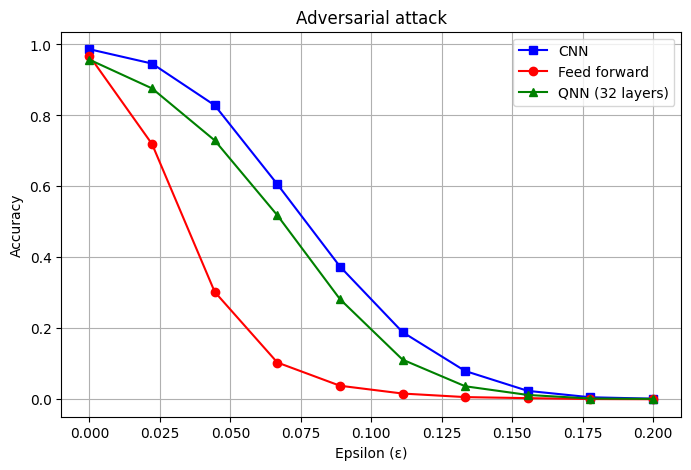

In [9]:
plt.figure(figsize=(8, 5))

# Set a consistent, clean font
plt.rcParams.update({'font.family': 'serif', 'font.size': 14})

# Plot with clearer markers and thicker lines
plt.plot(epsilons, accs_cnn, 'bs-', label='CNN', linewidth=2, markersize=6)
plt.plot(epsilons, accs_neural, 'ro-', label='Feedforward NN', linewidth=2, markersize=6)
plt.plot(epsilons, accs_qml, 'g^-', label='QNN (32 layers)', linewidth=2, markersize=6)

# Labels and title with padding
plt.xlabel('Epsilon (ε)', labelpad=10)
plt.ylabel('Accuracy', labelpad=10)
plt.title('Adversarial Attack Robustness', pad=15)

# Improve legend
plt.legend(frameon=False, fontsize=12)

# Ticks and grid
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Tight layout for better spacing
plt.tight_layout()

# Save in high-resolution and publication-friendly format
plt.savefig('adversarial_robustness.png', dpi=600, bbox_inches='tight', transparent=True)

plt.show()

### Classical to quantum attack

In [29]:
# Settings
epsilons = np.linspace(0, 0.2, 10).numpy() 
x_perturb = x_test.to(device)
y_perturb = y_test.to(device)
alpha = 1e-2
num_iter = 100

attack_model = model_cnn

# Evaluate models
accs_cnn = evaluate_under_attack(model_cnn, attack_model, x_perturb, y_perturb, epsilons, alpha, num_iter, batch_size)
accs_neural = evaluate_under_attack(model_feed_forward, attack_model, x_perturb, y_perturb, epsilons, alpha, num_iter, batch_size)
accs_qml = evaluate_under_attack(model_qml32, attack_model, x_perturb, y_perturb, epsilons, alpha, num_iter, batch_size)

Attack on 
NetCNN completed in 22.75 seconds.
Attack on 
NeuralNetwork completed in 22.51 seconds.
Attack on 
QNN completed in 66.65 seconds.


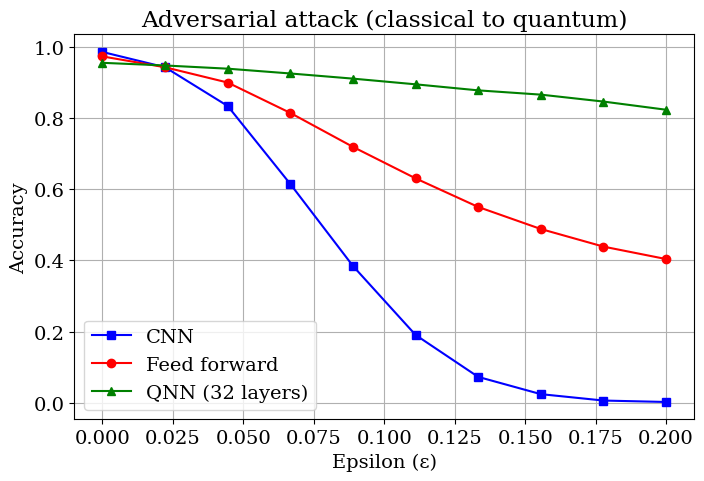

In [30]:
# Plot
plt.figure(figsize=(8, 5))
plt.plot(epsilons, accs_cnn, 'bs-', label='CNN')
plt.plot(epsilons, accs_neural, 'ro-', label='Feed forward')
plt.plot(epsilons, accs_qml, 'g^-', label='QNN (32 layers)')
plt.xlabel('Epsilon (ε)')
plt.ylabel('Accuracy')
plt.title('Adversarial attack (classical to quantum)')
plt.legend()
plt.grid(True)
# plt.savefig('adversarial_robustness_classical_to_quantum.jpg', dpi=600)
plt.show()

### Quantum to classical attack

In [12]:
# Settings
epsilons = np.linspace(0, 0.2, 10).numpy() 
x_perturb = x_test.to(device)
y_perturb = y_test.to(device)
alpha = 1e-2
num_iter = 100

attack_model = model_qml32

# Evaluate models
accs_cnn = evaluate_under_attack(model_cnn, attack_model, x_perturb, y_perturb, epsilons, alpha, num_iter, batch_size)
accs_neural = evaluate_under_attack(model_feed_forward, attack_model, x_perturb, y_perturb, epsilons, alpha, num_iter, batch_size)
accs_qml = evaluate_under_attack(model_qml32, attack_model, x_perturb, y_perturb, epsilons, alpha, num_iter, batch_size)

Attack on 
NetCNN completed in 1413.46 seconds.
Attack on 
NeuralNetwork completed in 1410.40 seconds.
Attack on 
QNN completed in 1455.18 seconds.


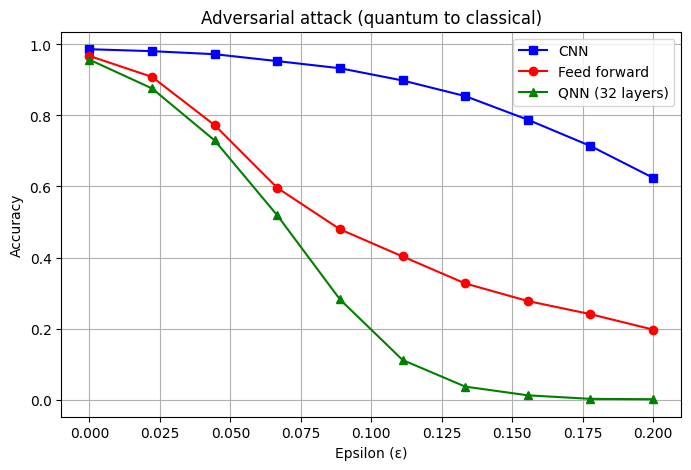

In [13]:
# Plot
plt.figure(figsize=(8, 5))
plt.plot(epsilons, accs_cnn, 'bs-', label='CNN')
plt.plot(epsilons, accs_neural, 'ro-', label='Feed forward')
plt.plot(epsilons, accs_qml, 'g^-', label='QNN (32 layers)')
plt.xlabel('Epsilon (ε)')
plt.ylabel('Accuracy')
plt.title('Adversarial attack (quantum to classical)')
plt.legend()
plt.grid(True)
plt.savefig('adversarial_robustness_quantum_to_classical.jpg', dpi=600)
plt.show()

## Binary classification

In [4]:
# digits = [3, 5, 8, 9] # 4 class
digits = [5, 8] # binary

n_classes = len(digits)
n_px = 16 # can try 8 (then use 64 qubit device and AngleEmbedding)

n_qubits = int(np.log2(n_px * n_px)) # for AmplitudeEmbedding
n_layers = 32

train_size = 10000
test_size = 2000

batch_size = int(np.sqrt(train_size))
epochs = 30
lr = 3e-3

In [11]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
device = "cpu"
print(f"Using {device} device")

Using cpu device


### Load trained models

In [12]:
model_cnn = NetCNN(n_px=n_px, n_classes=n_classes).to(device)
model_cnn.load_state_dict(torch.load("model_cnn_binary.pth"))
model_cnn.eval()

NetCNN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=256, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=2, bias=True)
)

In [13]:
model_feed_forward = NeuralNetwork(n_px=n_px, n_classes=n_classes).to(device)
model_feed_forward.load_state_dict(torch.load("model_feedforward_binary.pth"))
model_feed_forward.eval()

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=256, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=2, bias=True)
  )
)

In [14]:
model_qml32 = QNN(n_qubits=n_qubits, n_classes=n_classes, n_layers=n_layers).to(device)
model_qml32.load_state_dict(torch.load("model_qml32_binary.pth"))
model_qml32.eval()

QNN(
  (qlayer): <Quantum Torch Layer: func=circuit>
  (fc): Linear(in_features=8, out_features=2, bias=True)
)

### Load data

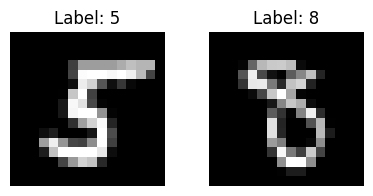

In [15]:
# Load and prepare dataset
(x_train, y_train), (x_test, y_test) = get_dataset(digits=digits, n_px=n_px, train_size=train_size, test_size=test_size)
train_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(x_test,  y_test),  batch_size=batch_size)

# show one image from each class (in the train- and testsets, the images are randomly permuted)
x_vis = [(x_train[y_train == i])[0].squeeze(0) for i in range(len(digits))]
y_vis = digits

visualise_data(x_vis, y_vis)

In [16]:
# Settings
epsilons = np.linspace(0, 0.2, 10).numpy() 
x_perturb = x_test.to(device)
y_perturb = y_test.to(device)
alpha = 1e-2
num_iter = 100

# Evaluate models
accs_cnn = evaluate_under_attack(model_cnn, model_cnn, x_perturb, y_perturb, epsilons, alpha, num_iter, batch_size)
accs_neural = evaluate_under_attack(model_feed_forward, model_feed_forward, x_perturb, y_perturb, epsilons, alpha, num_iter, batch_size)
accs_qml = evaluate_under_attack(model_qml32, model_qml32, x_perturb, y_perturb, epsilons, alpha, num_iter, batch_size)

Attack on 
NetCNN completed in 22.47 seconds.
Attack on 
NeuralNetwork completed in 1.18 seconds.
Attack on 
QNN completed in 1358.77 seconds.


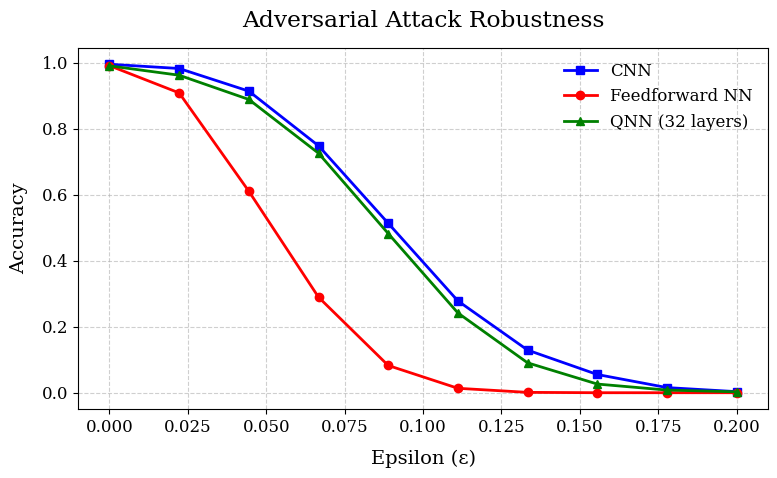

In [17]:
plt.figure(figsize=(8, 5))

# Set a consistent, clean font
plt.rcParams.update({'font.family': 'serif', 'font.size': 14})

# Plot with clearer markers and thicker lines
plt.plot(epsilons, accs_cnn, 'bs-', label='CNN', linewidth=2, markersize=6)
plt.plot(epsilons, accs_neural, 'ro-', label='Feedforward NN', linewidth=2, markersize=6)
plt.plot(epsilons, accs_qml, 'g^-', label='QNN (32 layers)', linewidth=2, markersize=6)

# Labels and title with padding
plt.xlabel('Epsilon (ε)', labelpad=10)
plt.ylabel('Accuracy', labelpad=10)
plt.title('Adversarial Attack Robustness', pad=15)

# Improve legend
plt.legend(frameon=False, fontsize=12)

# Ticks and grid
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Tight layout for better spacing
plt.tight_layout()

# Save in high-resolution and publication-friendly format
plt.savefig('adversarial_robustness_binary.png', dpi=600, bbox_inches='tight', transparent=True)

plt.show()

In [18]:
# Settings
epsilons = np.linspace(0, 0.2, 10).numpy() 
x_perturb = x_test[:500].to(device)
y_perturb = y_test[:500].to(device)
alpha = 1e-2
num_iter = 100

attack_model = model_cnn

# Evaluate models
accs_cnn = evaluate_under_attack(model_cnn, attack_model, x_perturb, y_perturb, epsilons, alpha, num_iter, batch_size)
accs_neural = evaluate_under_attack(model_feed_forward, attack_model, x_perturb, y_perturb, epsilons, alpha, num_iter, batch_size)
accs_qml = evaluate_under_attack(model_qml32, attack_model, x_perturb, y_perturb, epsilons, alpha, num_iter, batch_size)

Attack on 
NetCNN completed in 20.63 seconds.
Attack on 
NeuralNetwork completed in 20.51 seconds.
Attack on 
QNN completed in 62.29 seconds.


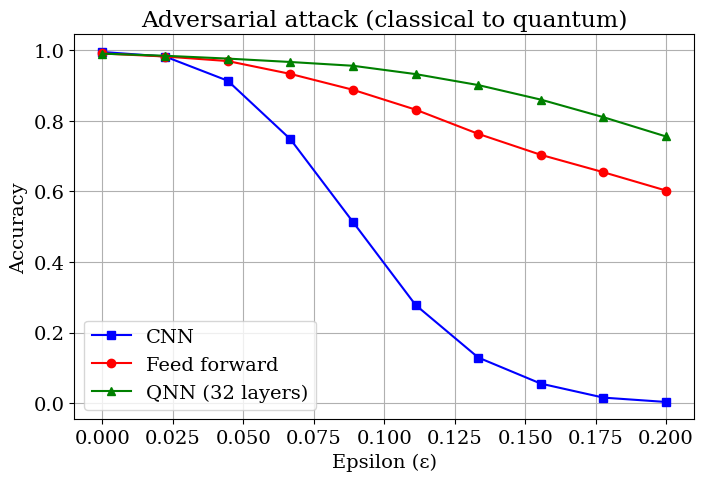

In [19]:
# Plot
plt.figure(figsize=(8, 5))
plt.plot(epsilons, accs_cnn, 'bs-', label='CNN')
plt.plot(epsilons, accs_neural, 'ro-', label='Feed forward')
plt.plot(epsilons, accs_qml, 'g^-', label='QNN (32 layers)')
plt.xlabel('Epsilon (ε)')
plt.ylabel('Accuracy')
plt.title('Adversarial attack (classical to quantum)')
plt.legend()
plt.grid(True)
plt.savefig('adversarial_robustness_classical_to_quantum_binary.jpg', dpi=600)
plt.show()

In [ ]:
# Settings
epsilons = np.linspace(0, 0.2, 10).numpy() 
x_perturb = x_test.to(device)
y_perturb = y_test.to(device)
alpha = 1e-2
num_iter = 100

attack_model = model_qml32

# Evaluate models
accs_cnn = evaluate_under_attack(model_cnn, attack_model, x_perturb, y_perturb, epsilons, alpha, num_iter, batch_size)
accs_neural = evaluate_under_attack(model_feed_forward, attack_model, x_perturb, y_perturb, epsilons, alpha, num_iter, batch_size)
accs_qml = evaluate_under_attack(model_qml32, attack_model, x_perturb, y_perturb, epsilons, alpha, num_iter, batch_size)

Attack on 
NetCNN completed in 1299.58 seconds.


In [ ]:
# Plot
plt.figure(figsize=(8, 5))
plt.plot(epsilons, accs_cnn, 'bs-', label='CNN')
plt.plot(epsilons, accs_neural, 'ro-', label='Feed forward')
plt.plot(epsilons, accs_qml, 'g^-', label='QNN (32 layers)')
plt.xlabel('Epsilon (ε)')
plt.ylabel('Accuracy')
plt.title('Adversarial attack (quantum to classical)')
plt.legend()
plt.grid(True)
plt.savefig('adversarial_robustness_quantum_to_classical_binary.jpg', dpi=600)
plt.show()

In [ ]:
def attack(attack_model, base_feats, labels, epsilons. num_iter, device):
    perturbed_data = []
    for eps in epsilons:
        perturb = PGD(attack_model,
                      base_feats, labels,
                      epsilon=eps, num_iter=num_iter,
                      device=device)
        x_adv = (base_feats + perturb).clamp(0, 1)  # Clamp to valid pixel range

# Adversarial Attacks

In [221]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

from pennylane import numpy as np

from matplotlib import pyplot as plt

import time

from utils.models import PGD, NetCNN, NeuralNetwork, HybridQNN, QNN
from utils.tools import test_loop, evaluate_under_attack, visualise_data

In [194]:
device = "cpu"
print(f"Using {device} device")

Using cpu device


### Load dataset and trained models

In [196]:
# Load:
data = torch.load('full_dataset_quaternary.pt')
x_train, y_train = data['train']
x_test, y_test = data['test']
digits = data['meta']['digits']
n_classes = len(digits)
n_px = data['meta']['n_px']

n_qubits = int(np.log2(n_px * n_px)) # for AmplitudeEmbedding
n_layers = 32

train_size = 10000
test_size = 2000

batch_size = int(np.sqrt(train_size))
epochs = 30
lr = 3e-3

In [197]:
train_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(x_test,  y_test),  batch_size=batch_size)

In [198]:
model_cnn = NetCNN(n_px=n_px, n_classes=n_classes).to(device)
model_cnn.load_state_dict(torch.load("model_cnn_quaternary.pth"))
model_cnn.eval()

NetCNN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=256, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=4, bias=True)
)

In [199]:
model_feedforward = NeuralNetwork(n_px=n_px, n_classes=n_classes).to(device)
model_feedforward.load_state_dict(torch.load("model_feedforward_quaternary.pth"))
model_feedforward.eval()

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=256, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=8, bias=True)
    (5): ReLU()
    (6): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [200]:
model_qml32 = QNN(n_qubits=n_qubits, n_classes=n_classes, n_layers=n_layers).to(device)
model_qml32.load_state_dict(torch.load("model_qml32_quaternary.pth"))
model_qml32.eval()

QNN(
  (qlayer): <Quantum Torch Layer: func=circuit>
)

In [201]:
model_qml32_hybrid = HybridQNN(n_qubits=n_qubits, n_classes=n_classes, n_layers=n_layers).to(device)
model_qml32_hybrid.load_state_dict(torch.load("model_qml32_hybrid_quaternary.pth"))
model_qml32_hybrid.eval()

HybridQNN(
  (qlayer): <Quantum Torch Layer: func=circuit>
  (fc): Linear(in_features=8, out_features=4, bias=True)
)

### Test accuracy

In [202]:
_, acc_cnn = test_loop(test_loader, model_cnn, nn.CrossEntropyLoss(), device)
_, acc_feedforward = test_loop(test_loader, model_feedforward, nn.CrossEntropyLoss(), device)
_, acc_qml32 = test_loop(test_loader, model_qml32, nn.CrossEntropyLoss(), device)
_, acc_qml32_hybrid = test_loop(test_loader, model_qml32_hybrid, nn.CrossEntropyLoss(), device)

print(f'CNN         : {acc_cnn*100:.2f}')
print(f'Feed Forward: {acc_feedforward*100:.2f}')
print(f'Hybrid QNN32: {acc_qml32_hybrid*100:.2f}')
print(f'QNN32       : {acc_qml32*100:.2f}')

CNN         : 98.60
Feed Forward: 96.70
Hybrid QNN32: 95.65
QNN32       : 84.75


### Infernce time

In [203]:
def measure_inference_time_per_sample(model, dataloader, device="cpu"):
    model.eval()
    model.to(device)

    start_time = time.time()
    num_samples = 0
    with torch.no_grad():
        for x_batch, _ in dataloader:
            x_batch = x_batch.to(device)
            num_samples += x_batch.size(0)  # Accumulate the number of samples
            _ = model(x_batch)
    end_time = time.time()

    total_time = end_time - start_time
    avg_time_per_sample = total_time / num_samples  # Calculate average time per sample
    return avg_time_per_sample


inference_times_per_sample = {}

inference_times_per_sample["cnn"] = measure_inference_time_per_sample(model_cnn, test_loader, device=device)
inference_times_per_sample["feedforward"] = measure_inference_time_per_sample(model_feedforward, test_loader, device=device)
inference_times_per_sample["qml"] = measure_inference_time_per_sample(model_qml32, test_loader, device=device)
inference_times_per_sample["qml_hybrid"] = measure_inference_time_per_sample(model_qml32_hybrid, test_loader, device=device)

for name, t in inference_times_per_sample.items():
    print(f"{name}: {t*1e3:.3f} ms")

cnn: 0.026 ms
feedforward: 0.011 ms
qml: 2.246 ms
qml_hybrid: 2.223 ms


In [204]:
def measure_inference_time_with_loader(model, dataloader, device="cpu"):
    model.eval()
    model.to(device)

    start_time = time.time()
    with torch.no_grad():
        for x_batch, _ in dataloader:
            x_batch = x_batch.to(device)
            _ = model(x_batch)
    end_time = time.time()

    total_time = end_time - start_time
    return total_time

inference_times = {}

inference_times["cnn"] = measure_inference_time_with_loader(model_cnn, test_loader, device=device)
inference_times["feedforward"] = measure_inference_time_with_loader(model_feedforward, test_loader, device=device)
inference_times["qml"] = measure_inference_time_with_loader(model_qml32, test_loader, device=device)
inference_times["qml_hybrid"] = measure_inference_time_with_loader(model_qml32_hybrid, test_loader, device=device)

for name, t in inference_times.items():
    print(f"{name}: {t:.4f} seconds")

cnn: 0.0323 seconds
feedforward: 0.0168 seconds
qml: 4.4154 seconds
qml_hybrid: 4.4503 seconds


### Adversarial attack

In [205]:
# Settings
epsilons = np.linspace(0, 0.2, 9).numpy() 
x_perturb = x_test[:1000].to(device)
y_perturb = y_test[:1000].to(device)
alpha = 1e-2
num_iter = 40
batch_size = 40

# Evaluate models
accs_cnn = evaluate_under_attack(model_cnn, model_cnn, x_perturb, y_perturb, epsilons, alpha, num_iter, batch_size)
accs_feedforward = evaluate_under_attack(model_feedforward, model_feedforward, x_perturb, y_perturb, epsilons, alpha, num_iter, batch_size)
accs_qml32_hybrid = evaluate_under_attack(model_qml32_hybrid, model_qml32_hybrid, x_perturb, y_perturb, epsilons, alpha, num_iter, batch_size)
accs_qml32 = evaluate_under_attack(model_qml32, model_qml32, x_perturb, y_perturb, epsilons, alpha, num_iter, batch_size)

Attack on 
NetCNN completed in 3.92 seconds.
Attack on 
NeuralNetwork completed in 0.50 seconds.
Attack on 
HybridQNN completed in 418.14 seconds.
Attack on 
QNN completed in 415.66 seconds.


In [208]:
torch.save(accs_cnn, 'accs_cnn.pth')
torch.save(accs_feedforward, 'accs_feedforward.pth')
torch.save(accs_qml32_hybrid, 'accs_qml32_hybrid.pth')
torch.save(accs_qml32, 'accs_qml32.pth')

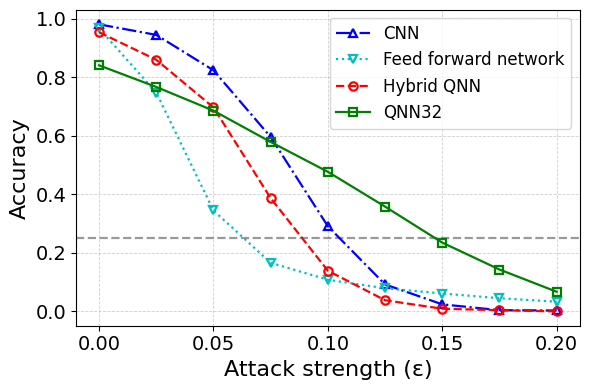

In [219]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.axhline(y=0.25, color='black', linestyle='--', linewidth=1.6, alpha=0.4, label=None)
ax.plot(epsilons, accs_cnn, 'b^-.', ms=6, linewidth=1.6, label="CNN", markerfacecolor='none', markeredgewidth=1.6)
ax.plot(epsilons, accs_feedforward, 'cv:', ms=6, linewidth=1.6, label="Feed forward network", markerfacecolor='none', markeredgewidth=1.6)
ax.plot(epsilons, accs_qml32_hybrid, 'ro--', ms=6, linewidth=1.6, label="Hybrid QNN", markerfacecolor='none', markeredgewidth=1.6)
ax.plot(epsilons, accs_qml32, 'gs-', ms=6, linewidth=1.6, label="QNN32", markerfacecolor='none', markeredgewidth=1.6)
ax.set_xlabel('Attack strength (ε)', fontsize=16)
ax.set_ylabel('Accuracy', fontsize=16)
ax.legend(loc='best', fontsize=12)
ax.grid(True, which='both', linestyle='--', linewidth=0.6, alpha=0.6)
ax.tick_params(axis='both', labelsize=14)
plt.tight_layout()
plt.savefig("adv_rob.png", dpi=600)

#### Classical attack (trained on CNN)

In [209]:
# Settings
epsilons = np.linspace(0, 0.2, 9).numpy() 
x_perturb = x_test[:1000].to(device)
y_perturb = y_test[:1000].to(device)
alpha = 1e-2
num_iter = 40
batch_size = 40

attack_model = model_cnn

# Evaluate models
accs_cnn_c_atk = evaluate_under_attack(model_cnn, attack_model, x_perturb, y_perturb, epsilons, alpha, num_iter, batch_size)
accs_feedforward_c_atk = evaluate_under_attack(model_feedforward, attack_model, x_perturb, y_perturb, epsilons, alpha, num_iter, batch_size)
accs_qml32_hybrid_c_atk = evaluate_under_attack(model_qml32_hybrid, attack_model, x_perturb, y_perturb, epsilons, alpha, num_iter, batch_size)
accs_qml32_c_atk = evaluate_under_attack(model_qml32, attack_model, x_perturb, y_perturb, epsilons, alpha, num_iter, batch_size)

Attack on 
NetCNN completed in 4.02 seconds.
Attack on 
NeuralNetwork completed in 3.82 seconds.
Attack on 
HybridQNN completed in 48.85 seconds.
Attack on 
QNN completed in 48.63 seconds.


In [212]:
torch.save(accs_cnn_c_atk, 'accs_cnn_c_atk.pth')
torch.save(accs_feedforward_c_atk, 'accs_feedforward_c_atk.pth')
torch.save(accs_qml32_hybrid_c_atk, 'accs_qml32_hybrid_c_atk.pth')
torch.save(accs_qml32_c_atk, 'accs_qml32_c_atk.pth')

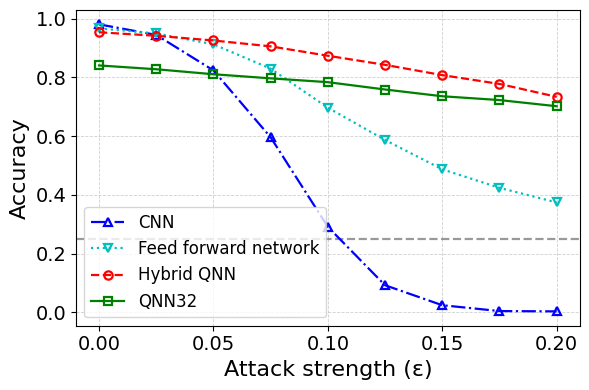

In [217]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.axhline(y=0.25, color='black', linestyle='--', linewidth=1.6, alpha=0.4, label=None)
ax.plot(epsilons, accs_cnn_c_atk, 'b^-.', ms=6, linewidth=1.6, label="CNN", markerfacecolor='none', markeredgewidth=1.6)
ax.plot(epsilons, accs_feedforward_c_atk, 'cv:', ms=6, linewidth=1.6, label="Feed forward network", markerfacecolor='none', markeredgewidth=1.6)
ax.plot(epsilons, accs_qml32_hybrid_c_atk, 'ro--', ms=6, linewidth=1.6, label="Hybrid QNN", markerfacecolor='none', markeredgewidth=1.6)
ax.plot(epsilons, accs_qml32_c_atk, 'gs-', ms=6, linewidth=1.6, label="QNN32", markerfacecolor='none', markeredgewidth=1.6)
ax.set_xlabel('Attack strength (ε)', fontsize=16)
ax.set_ylabel('Accuracy', fontsize=16)
ax.legend(loc='best', fontsize=12)
ax.grid(True, which='both', linestyle='--', linewidth=0.6, alpha=0.6)
ax.tick_params(axis='both', labelsize=14)
plt.tight_layout()
plt.savefig("adv_rob_c_atk.png", dpi=600)

#### Quantum attack (trained on QNN)

In [213]:
# Settings
epsilons = np.linspace(0, 0.2, 9).numpy() 
x_perturb = x_test[:1000].to(device)
y_perturb = y_test[:1000].to(device)
alpha = 1e-2
num_iter = 40
batch_size = 40

attack_model = model_qml32

# Evaluate models
accs_cnn_q_atk = evaluate_under_attack(model_cnn, attack_model, x_perturb, y_perturb, epsilons, alpha, num_iter, batch_size)
accs_feedforward_q_atk = evaluate_under_attack(model_feedforward, attack_model, x_perturb, y_perturb, epsilons, alpha, num_iter, batch_size)
accs_qml32_hybrid_q_atk = evaluate_under_attack(model_qml32_hybrid, attack_model, x_perturb, y_perturb, epsilons, alpha, num_iter, batch_size)
accs_qml32_q_atk = evaluate_under_attack(model_qml32, attack_model, x_perturb, y_perturb, epsilons, alpha, num_iter, batch_size)

Attack on 
NetCNN completed in 371.13 seconds.
Attack on 
NeuralNetwork completed in 370.99 seconds.
Attack on 
HybridQNN completed in 415.78 seconds.
Attack on 
QNN completed in 415.33 seconds.


In [214]:
torch.save(accs_cnn_q_atk, 'accs_cnn_q_atk.pth')
torch.save(accs_feedforward_q_atk, 'accs_feedforward_q_atk.pth')
torch.save(accs_qml32_hybrid_q_atk, 'accs_qml32_hybrid_q_atk.pth')
torch.save(accs_qml32_q_atk, 'accs_qml32_q_atk.pth')

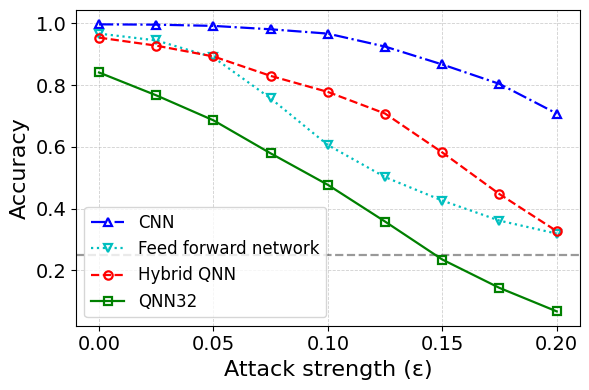

In [218]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.axhline(y=0.25, color='black', linestyle='--', linewidth=1.6, alpha=0.4, label=None)
ax.plot(epsilons, accs_cnn_q_atck, 'b^-.', ms=6, linewidth=1.6, label="CNN", markerfacecolor='none', markeredgewidth=1.6)
ax.plot(epsilons, accs_feedforward_q_atk, 'cv:', ms=6, linewidth=1.6, label="Feed forward network", markerfacecolor='none', markeredgewidth=1.6)
ax.plot(epsilons, accs_qml32_hybrid_q_atk, 'ro--', ms=6, linewidth=1.6, label="Hybrid QNN", markerfacecolor='none', markeredgewidth=1.6)
ax.plot(epsilons, accs_qml32_q_atk, 'gs-', ms=6, linewidth=1.6, label="QNN32", markerfacecolor='none', markeredgewidth=1.6)
ax.set_xlabel('Attack strength (ε)', fontsize=16)
ax.set_ylabel('Accuracy', fontsize=16)
ax.legend(loc='best', fontsize=12)
ax.grid(True, which='both', linestyle='--', linewidth=0.6, alpha=0.6)
ax.tick_params(axis='both', labelsize=14)
plt.tight_layout()
plt.savefig("adv_rob_q_atk.png", dpi=600)

### Plot perturbed images

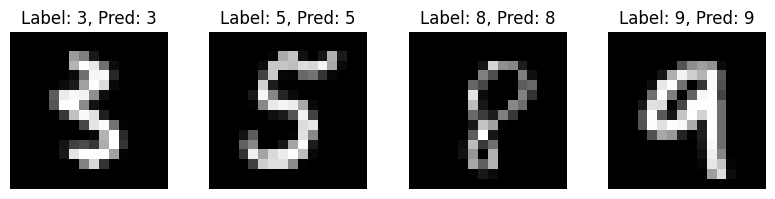

In [336]:
x_perturb = x_test.to(device)
y_perturb = y_test.to(device)

# show one image from each class (in the train- and testsets, the images are randomly permuted)
x_vis = [(x_perturb[y_perturb == i])[1].squeeze(0).to("cpu") for i in range(len(digits))]
y_vis = digits
preds = [model_cnn(x_vis[i].unsqueeze(0).unsqueeze(0)).argmax(1) for i in range(len(digits))]
preds = [t.item() for t in preds]
preds = [digits[i] for i in preds]

visualise_data(x_vis, y_vis, preds)
plt.savefig('vis.png', dpi=600)

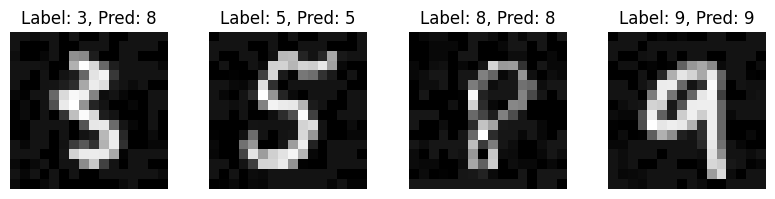

In [337]:
device = "cpu"
x_perturb = x_test.to(device)
y_perturb = y_test.to(device)
perturbations = PGD(model=model_cnn.to(device), feats=x_perturb, labels=y_perturb, epsilon=0.04, alpha=0.03, num_iter=100)

x_perturb = x_perturb + perturbations

# show one image from each class (in the train- and testsets, the images are randomly permuted)
x_vis = [(x_perturb[y_perturb == i])[1].squeeze(0).to("cpu") for i in range(len(digits))]
y_vis = digits
preds = [model_cnn(x_vis[i].unsqueeze(0).unsqueeze(0)).argmax(1) for i in range(len(digits))]
preds = [t.item() for t in preds]
preds = [digits[i] for i in preds]

visualise_data(x_vis, y_vis, preds)
plt.savefig('vis2.png', dpi=600)

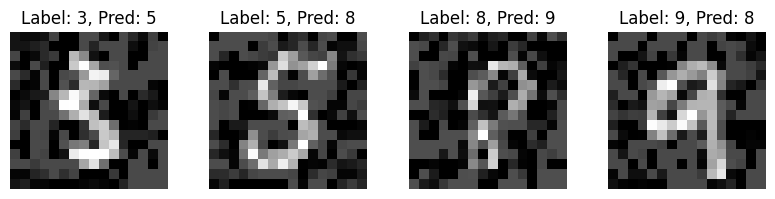

In [338]:
device = "cpu"
x_perturb = x_test.to(device)
y_perturb = y_test.to(device)
perturbations = PGD(model=model_cnn.to(device), feats=x_perturb, labels=y_perturb, epsilon=0.2, alpha=0.03, num_iter=100)

x_perturb = x_perturb + perturbations

# show one image from each class (in the train- and testsets, the images are randomly permuted)
x_vis = [(x_perturb[y_perturb == i])[1].squeeze(0).to("cpu") for i in range(len(digits))]
y_vis = digits

preds = [model_cnn(x_vis[i].unsqueeze(0).unsqueeze(0)).argmax(1) for i in range(len(digits))]
preds = [t.item() for t in preds]
preds = [digits[i] for i in preds]

visualise_data(x_vis, y_vis, preds)
plt.savefig('vis3.png', dpi=600)

In [342]:
from PIL import Image
import numpy as np

# Open your images
img1 = Image.open('vis.png')
img2 = Image.open('vis2.png')
img3 = Image.open('vis3.png')

# Resize images if necessary (make them the same size)
# img1 = img1.resize((256, 256))  # Resize to a common size if needed
# img2 = img2.resize((256, 256))
# img3 = img3.resize((256, 256))

# Stack images horizontally
stacked_images = np.vstack((np.array(img1), np.array(img2), np.array(img3)))

# Convert back to Image format
stacked_images = Image.fromarray(stacked_images)

# Save the stacked image
stacked_images.save('stacked_image.png')
# stacked_images.show()
